In [1]:
# Access astronomical databases
from pyvo import registry

# Moc and HEALPix tools
from mocpy import MOC

# Sky visualization
from ipyaladin import Aladin

# For plots
import matplotlib.pyplot as plt

# Welcome to VizieR example workflow

[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://vizier.cds.unistra.fr/viz-bin/VizieR "https://vizier.cds.unistra.fr/viz-bin/VizieR")

It is a generic notebook, highlighting what can be done once you chose a catalog. This workflow is suggested by [CDS](https://cdsweb.unistra.fr/) (Strasbourg Astronomical Data Center, house of [VizieR](https://vizier.cds.unistra.fr/viz-bin/VizieR)).

--------------------------------------------------------

Modify the VizieR catalogue name (variable CATALOGUE) and anything else you might feel like exploring!

## 1. Setup

This example notebook has the following dependencies: 

**Required**
- pyvo : this library facilitates the access to the Virtual Observatory (VO) resources. VizieR is part of the VO.

**Optional, for visualization**
- ipyaladin : this is the Aladin-lite sky viewer, bundled as a jupyter widget. It allows to plot catalogs and multi-order coverages (MOC)
- matplotlib : an other option to see catalog points and MOCs

## 2. Metadata exploration with the Virtual Observatory registry

This part uses [pyvo](https://pyvo.readthedocs.io/en) to connect to the VO registry.

In [2]:
# the catalogue name in VizieR
CATALOGUE = "J/AJ/157/229"

We first retrieve catalogue information.

In [3]:
# each resource in the VO has an identifier, called ivoid. For vizier catalogs,
# the VO ids can be constructed like this:
catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"
# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

In [4]:
# We can print metadata information about the catalogue
voresource.describe(verbose=True)

CALSPEC: WFC3 infrared grism spectrophotometry
Short Name: J/AJ/157/229
IVOA Identifier: ivo://cds.vizier/j/aj/157/229
Access modes: conesearch, tap#aux, web
Multi-capabilty service -- use get_service()

The collections of spectral energy distributions (SEDs) in the Hubble Space
Telescope (HST) CALSPEC database are augmented by 19 infrared (IR) SEDs from
Wide Field Camera 3 (WFC3) IR grism spectra. Together, the two IR grisms, G102
and G141, cover the 0.8-1.7 {mu}m range with resolutions of R=200 and 150,
respectively. These new WFC3 SEDs overlap existing CALSPEC Space Telescope
Imaging Spectrograph (STIS) standard star flux distributions at 0.8-1 {mu}m
with agreement to ~<1%. Some CALSPEC standards already have near-IR camera and
multi-object spectrogragh (NICMOS) SEDs; but in their overlap region at
0.8-1.7 {mu}m, the WFC3 data have better wavelength accuracy, better spectral
resolution, better repeatability, and, consequently, better flux distributions
of ~1% accuracy in our CALSPEC

We can also inspect in details the `resource` object and access the attributes not provided by the describe method. See for example, the first author of a resource: 

In [5]:
voresource.creators[0]

'Bohlin R.C.'

## 3. Access the tabular data of this catalog

We can have a look at the tables available in the catalogue.

In [6]:
tables = voresource.get_tables()
tables

{'J/AJ/157/229/table3': <Table name="J/AJ/157/229/table3">... 10 columns ...</Table>,
 'J/AJ/157/229/table2': <Table name="J/AJ/157/229/table2">... 5 columns ...</Table>,
 'J/AJ/157/229/table1': <Table name="J/AJ/157/229/table1">... 12 columns ...</Table>}

In [7]:
# We can also extract the tables names for later use
tables_names = list(tables.keys())
tables_names

['J/AJ/157/229/table3', 'J/AJ/157/229/table2', 'J/AJ/157/229/table1']

The actual data can then be access using any of the ``access_modes`` of the voresource.

In [8]:
voresource.access_modes()

{'conesearch', 'tap#aux', 'web'}

The web access is found by following the ``reference_url``

In [9]:
voresource.reference_url

'https://cdsarc.cds.unistra.fr/viz-bin/cat/J/AJ/157/229'

We will explore the other access modes here.

### 3.1. Execute a cone search query

We use the Simple Cone Search (<a href='https://www.ivoa.net/documents/latest/ConeSearch.html'>SCS</a>) protocol of the virtual observatory (only available for tables with positions).

Adapt the radius and position of the center to your needs.

In [10]:
conesearch_radius = 1 / 60.0  # in degrees
conesearch_center = (0, 0)

In [11]:
conesearch_records = voresource.get_service("conesearch").search(
    pos=conesearch_center,
    sr=conesearch_radius,
)
conesearch_records

<Table length=0>
   _r   recno  Star   ID    Jmag  ... NICMOS  sp  SimbadName   _RA     _DE  
                            mag   ...                          deg     deg  
float64 int32 str23 str11 float32 ...  str3  str2   str23    float64 float64
------- ----- ----- ----- ------- ... ------ ---- ---------- ------- -------

### 3.2 Execute a SQL/ADQL query

The ``tap#aux`` in the ``access_mode`` response indicates that we can also do a SQL/ADQL query for these VizieR tables.

On the first table of the catalogue, we execute an <a href='https://www.ivoa.net/documents/latest/ADQL.html'>ADQL</a> query.

In [12]:
# get the first table of the catalogue
first_table_name = tables_names[0]

# execute a synchronous ADQL query
tap_service = voresource.get_service("tap")
tap_records = voresource.get_service("tap").run_sync(
    f'select TOP 10 * from "{first_table_name}"',
)
tap_records

<Table length=10>
recno    ID     Wave    Net   ...     Sys-err      Nobs   Exp    Qual
               0.1 nm  ct / s ... cW.m**-2.nm**-1          s         
int32  object float64 float32 ...     float32     int16 float64 int16
----- ------- ------- ------- ... --------------- ----- ------- -----
    1 1757132  7608.0  42.489 ...      3.2988e-16     8   211.1     1
    2 1757132  7624.0  55.701 ...      3.3175e-16     8   211.1     1
    3 1757132  7640.0  67.343 ...      3.1961e-16     8   211.1     1
    4 1757132  7656.0  83.277 ...      3.1485e-16     8   211.1     1
    5 1757132  7672.0  108.46 ...      3.1696e-16     8   211.1     1
    6 1757132  7688.0   142.1 ...      3.1825e-16     8   211.1     1
    7 1757132  7704.0  183.46 ...       3.213e-16     8   211.1     1
    8 1757132  7720.0  222.56 ...       3.195e-16     8   211.1     1
    9 1757132  7736.0  253.05 ...      3.1498e-16     8   211.1     1
   10 1757132  7752.0  275.18 ...      3.1006e-16     8   211.1     1

## 4. Get the catalogue coverage

VizieR also provides the coverage of each catalogue with Multiple Order Coverage (<a href='https://ivoa.net/documents/MOC/'>MOC</a>) at order 10 -- meaning with a 0.001 rad spacial resolution.

In [13]:
# retrieve the MOC
catalogue_coverage = MOC.from_fits(
    f"https://cdsarc.cds.unistra.fr/viz-bin/moc/{CATALOGUE}",
)
catalogue_coverage

10/483991 2386614 2433709 2600321 2611881 2971094 2971474 3068104 3926734 
 4110951 5083592 5223647 5451823 6090106 6264986 6602996 7174822 7893354 
 9199537 

We can plot the coverage with ``matplotlib``.

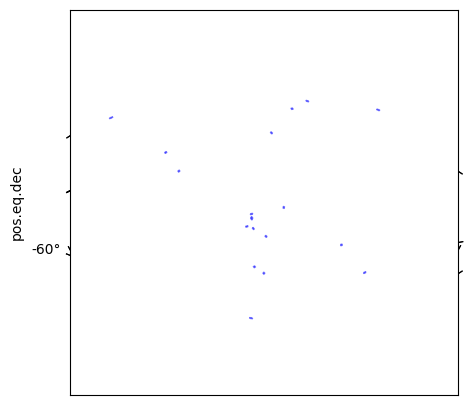

In [14]:
fig = plt.figure(figsize=(5, 5))
wcs = catalogue_coverage.wcs(fig)
ax = fig.add_subplot(projection=wcs)
catalogue_coverage.fill(ax=ax, wcs=wcs, alpha=0.5, color="blue")

or with ipyaladin

In [15]:
aladin = Aladin()
aladin

Aladin(options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'overlay_sur…

We can add the tables and coverage in this ipyaladin window.

In [16]:
aladin.add_table(conesearch_records.to_table())

In [17]:
aladin.add_table(tap_records.to_table())

In [18]:
aladin.add_moc_from_URL(
    f"https://cdsarc.cds.unistra.fr/viz-bin/moc/{CATALOGUE}",
    moc_options={"opacity": 0.5, "color": "pink"},
)

For more information about manipulating coverages, see [MOCpy documentation](https://cds-astro.github.io/mocpy/).